Algorithm implemented :   
Cluster based anomaly detection (K-mean)   
Repartition of data into categories then Gaussian/Elliptic Enveloppe on each categories separately   
Markov Chain    
Isolation Forest    
One class SVM     
RNN (comparison between prediction and reality)    
https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection    

In [1]:
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        #distance.set_value(i, np.linalg.norm(Xa-Xb))
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
    df = np.array(df)
    model = msm.estimate_markov_model(df, 1)
    return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [3]:
df = pd.read_csv('../csv_data/m_data.csv', usecols=['date', 'time', 'cpu'])
df.head()

,date,time,cpu
0,2020-06-30,07:00:00,0.097734
1,2020-06-30,08:00:00,0.098000
2,2020-06-30,09:00:00,0.101267
3,2020-06-30,10:00:00,0.091533
4,2020-06-30,11:00:00,0.086600


In [4]:
df['timestamp'] = df[df.columns[0:2]]. apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1)
df.head()

,date,time,cpu,timestamp
0,2020-06-30,07:00:00,0.097734,2020-06-30 07:00:00
1,2020-06-30,08:00:00,0.098000,2020-06-30 08:00:00
2,2020-06-30,09:00:00,0.101267,2020-06-30 09:00:00
3,2020-06-30,10:00:00,0.091533,2020-06-30 10:00:00
4,2020-06-30,11:00:00,0.086600,2020-06-30 11:00:00


In [5]:
df = df[['timestamp', 'cpu']]
df.head()

,timestamp,cpu
0,2020-06-30 07:00:00,0.097734
1,2020-06-30 08:00:00,0.098000
2,2020-06-30 09:00:00,0.101267
3,2020-06-30 10:00:00,0.091533
4,2020-06-30 11:00:00,0.086600


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  243 non-null    object 
 1   cpu        243 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None


In [7]:
print(df['timestamp'].head())

0    2020-06-30 07:00:00
1    2020-06-30 08:00:00
2    2020-06-30 09:00:00
3    2020-06-30 10:00:00
4    2020-06-30 11:00:00
Name: timestamp, dtype: object


In [8]:
print(df['cpu'].mean())

0.11101786978045496


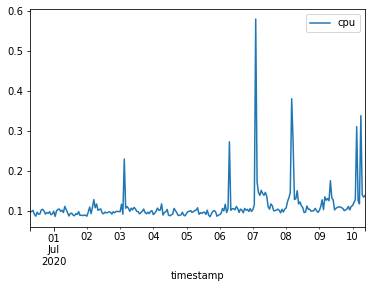

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x = 'timestamp', y='cpu')

In [10]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 19)).astype(int)
df.head(30)

,timestamp,cpu,hours,daylight
0,2020-06-30 07:00:00,0.097734,7,0
1,2020-06-30 08:00:00,0.098000,8,1
2,2020-06-30 09:00:00,0.101267,9,1
3,2020-06-30 10:00:00,0.091533,10,1
4,2020-06-30 11:00:00,0.086600,11,1
5,2020-06-30 12:00:00,0.096467,12,1
6,2020-06-30 13:00:00,0.091333,13,1
7,2020-06-30 14:00:00,0.091933,14,1
8,2020-06-30 15:00:00,0.102067,15,1
9,2020-06-30 16:00:00,0.103800,16,1


In [11]:
s = pd.date_range('2020-06-29', '2020-07-10').to_series()
s.dt.dayofweek

2020-06-29    0
2020-06-30    1
2020-07-01    2
2020-07-02    3
2020-07-03    4
2020-07-04    5
2020-07-05    6
2020-07-06    0
2020-07-07    1
2020-07-08    2
2020-07-09    3
2020-07-10    4
Freq: D, dtype: int64

In [12]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
outliers_fraction = 0.01


In [13]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [14]:
df['categories'] = df['WeekDay']*2 + df['daylight']


a = df.loc[df['categories'] == 0, 'cpu']
b = df.loc[df['categories'] == 1, 'cpu']
c = df.loc[df['categories'] == 2, 'cpu']
d = df.loc[df['categories'] == 3, 'cpu']


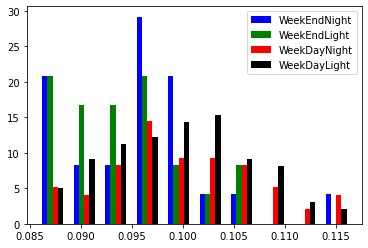

In [15]:
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()


In [16]:
# Take useful feature and standardize them
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

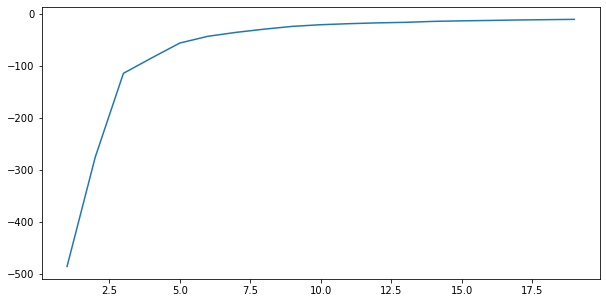

In [17]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)

In [18]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

10    25
7     25
13    24
8     22
5     21
14    19
0     19
12    18
2     18
4     16
1     15
9     14
3      4
11     2
6      1
Name: cluster, dtype: int64

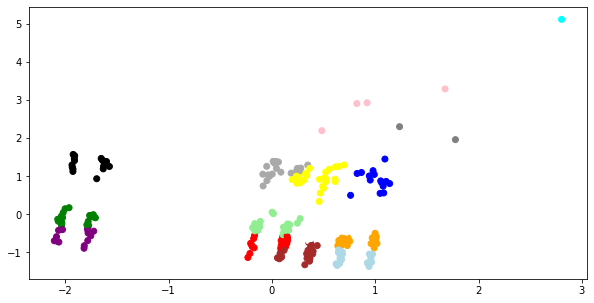

In [19]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [20]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


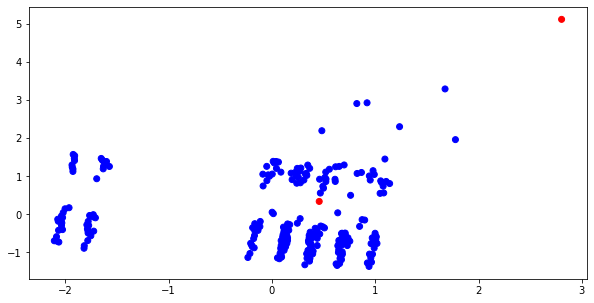

In [21]:
fig, ax = plt.subplots()
color = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: color[x]))
plt.show()

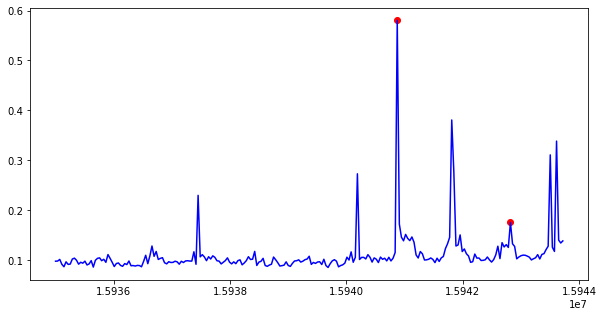

In [22]:
fig, ax = plt.subplots()
a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color = 'blue')
ax.scatter(a['time_epoch'], a['cpu'], color = 'red')
plt.show()

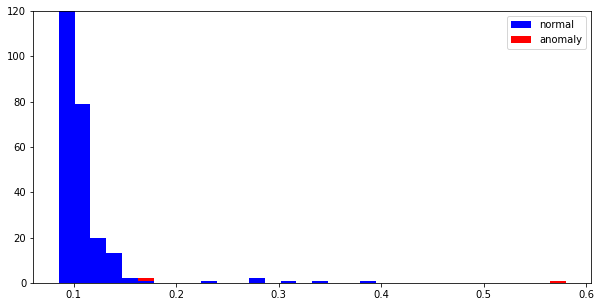

In [23]:
a = df.loc[df['anomaly21'] == 0, 'cpu']
b = df.loc[df['anomaly21'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## Categories + Gaussian

In [24]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'cpu']
df_class1 = df.loc[df['categories'] == 1, 'cpu']
df_class2 = df.loc[df['categories'] == 2, 'cpu']
df_class3 = df.loc[df['categories'] == 3, 'cpu']

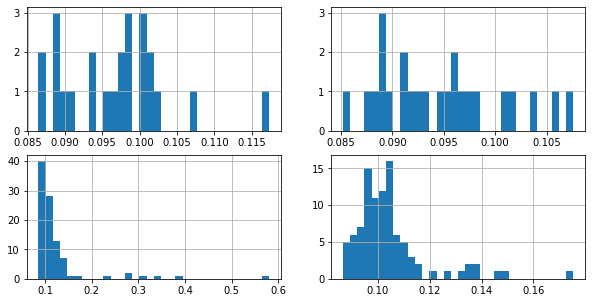

In [25]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [26]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

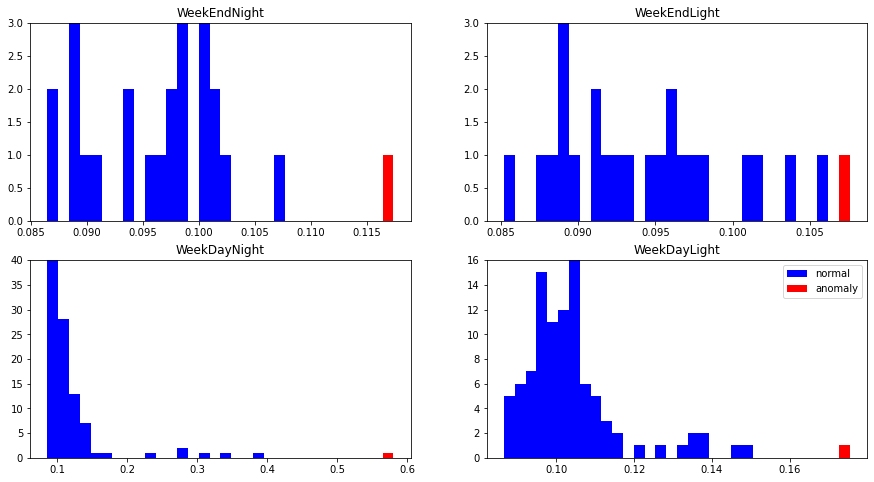

In [27]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'cpu']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'cpu']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'cpu']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'cpu']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'cpu']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'cpu']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'cpu']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'cpu']

plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [28]:
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(float)

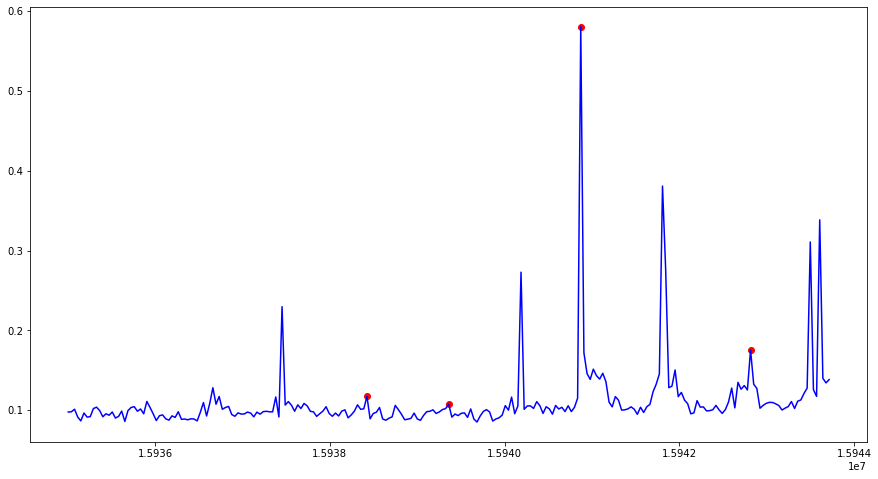

In [29]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'cpu')] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'], a['cpu'], color='red')
plt.show()

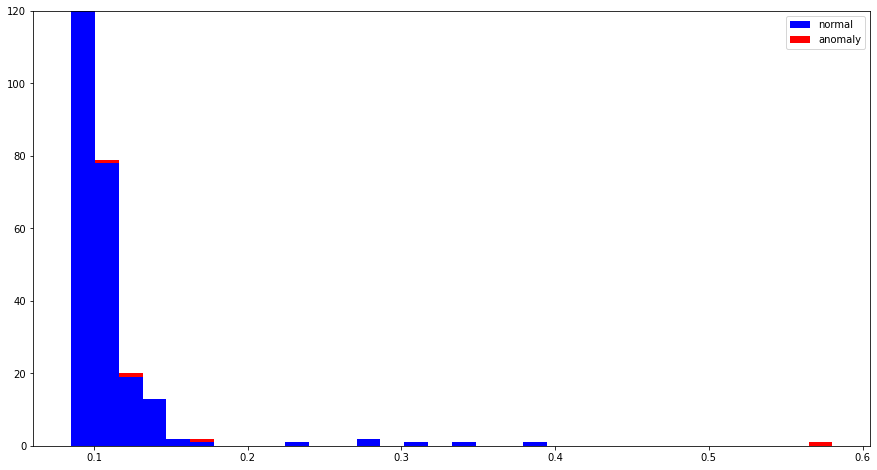

In [30]:
a = df.loc[df['anomaly22'] == 0, 'cpu']
b = df.loc[df['anomaly22'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Markov chains

In [31]:
x1 = (df['cpu'] <= 18).astype(int)
x2 = ((df['cpu'] > 18) & (df['cpu'] <= 21)).astype(int)
x3 = ((df['cpu'] > 21) & (df['cpu'] <= 24)).astype(int)
x4 = ((df['cpu'] > 24) & (df['cpu'] <= 27)).astype(int)
x5 = (df['cpu'] > 27).astype(int)
df_mm = x1 + 2*x2 + 3*x3 + 4*x4 + 5*x5
print(df_mm)


0      1
1      1
2      1
3      1
4      1
      ..
238    1
239    1
240    1
241    1
242    1
Name: cpu, Length: 243, dtype: int64


## Isolation Forest

In [32]:
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    240
1      3
Name: anomaly25, dtype: int64


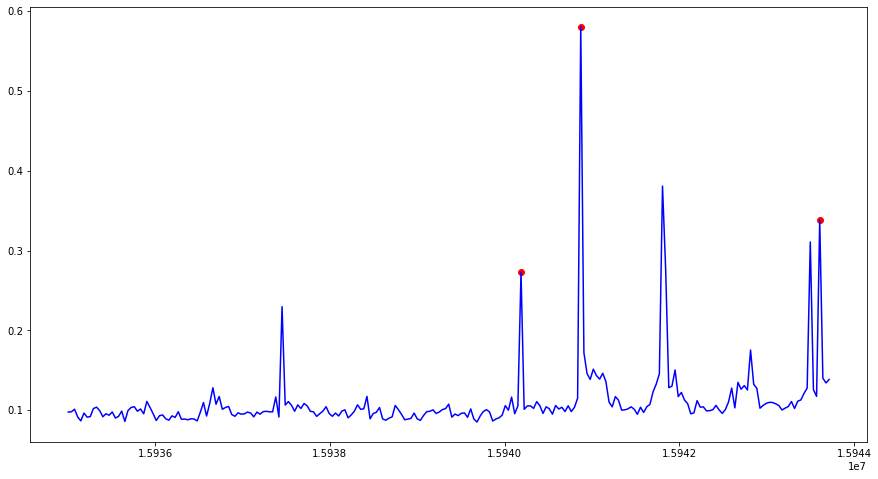

In [33]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

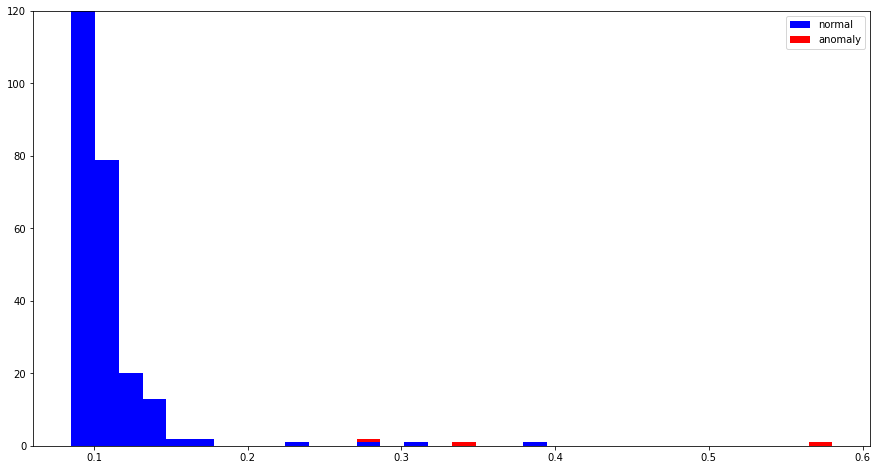

In [34]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'cpu']
b = df.loc[df['anomaly25'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## One class SVM

In [35]:
# Take useful feature and standardize them 
data = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    233
1     10
Name: anomaly26, dtype: int64


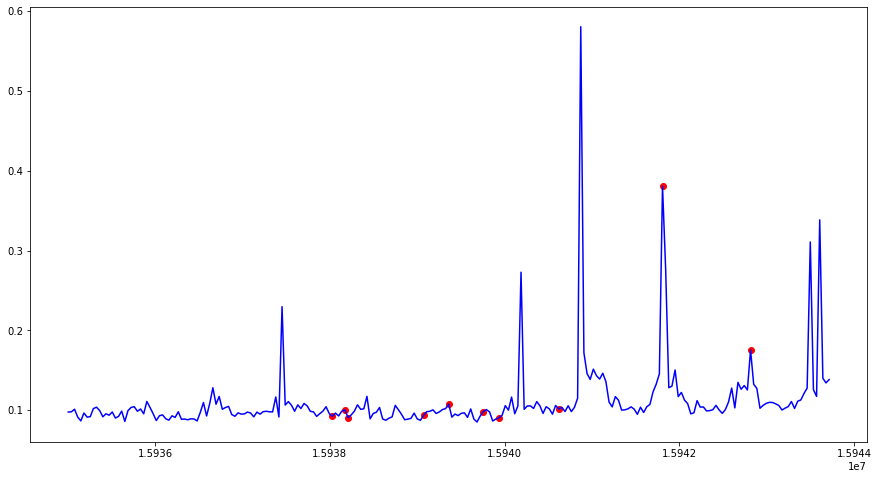

In [36]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'cpu']] #anomaly

ax.plot(df['time_epoch'], df['cpu'], color='blue')
ax.scatter(a['time_epoch'],a['cpu'], color='red')
plt.show()

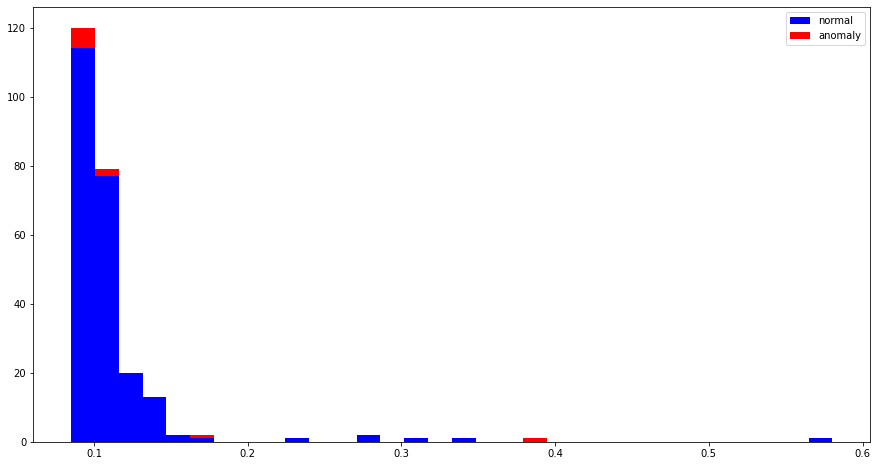

In [37]:
a = df.loc[df['anomaly26'] == 0, 'cpu']
b = df.loc[df['anomaly26'] == 1, 'cpu']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# RNN

In [54]:
#select and standardize data
data_n = df[['cpu', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 15
unroll_length = 5
testdatacut = testdatasize + unroll_length  + 1

#total_row = data_n.index.stop
#prediction_time = 1 
#testdatasize = int(total_row - (total_row * 0.95))
#unroll_length = int(total_row * 0.05)
#testdatacut = testdatasize + unroll_length + 1

x_train = data_n[0:-prediction_time-testdatacut].iloc[:, 1:].values
y_train = data_n[prediction_time:-testdatacut][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].iloc[:, 1:].values
y_test = data_n[prediction_time-testdatacut:  ][0].values


In [55]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (216, 5, 4)
y_train (216,)
x_test (15, 5, 4)
y_test (15,)


In [56]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [72]:
### CJB : 파라미터 다시 확인 후 조절할 것

# Build the model
model = Sequential()
model.add(LSTM(0, input_shape = (5, 4), return_sequences = True)) 
model.add(Dropout(0.2))
model.add(LSTM(1, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
print('compilation time : {}'.format(time.time() - start))


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 5, 0)              0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 0)              0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 1)                 8         
_________________________________________________________________
dropout_35 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________

In [69]:
model.fit(x_train, y_train, batch_size=3028, epochs=30, validation_split=0.1)

Epoch 1/30
1/1 [==============================] - 1s 629ms/step - loss: 1.0024 - val_loss: 0.1568
Epoch 2/30
1/1 [==============================] - 0s 32ms/step - loss: 0.9845 - val_loss: 0.1533
Epoch 3/30
1/1 [==============================] - 0s 31ms/step - loss: 0.9711 - val_loss: 0.1504
Epoch 4/30
1/1 [==============================] - 0s 32ms/step - loss: 0.9629 - val_loss: 0.1456
Epoch 5/30
1/1 [==============================] - 0s 31ms/step - loss: 0.9582 - val_loss: 0.1425
Epoch 6/30
1/1 [==============================] - 0s 31ms/step - loss: 0.9662 - val_loss: 0.1394
Epoch 7/30
1/1 [==============================] - 0s 31ms/step - loss: 0.9595 - val_loss: 0.1367
Epoch 8/30
1/1 [==============================] - 0s 31ms/step - loss: 0.9416 - val_loss: 0.1347
Epoch 9/30
1/1 [==============================] - 0s 32ms/step - loss: 0.9333 - val_loss: 0.1324
Epoch 10/30
1/1 [==============================] - 0s 68ms/step - loss: 0.9319 - val_loss: 0.1310
Epoch 11/30
1/1 [===========

In [70]:
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

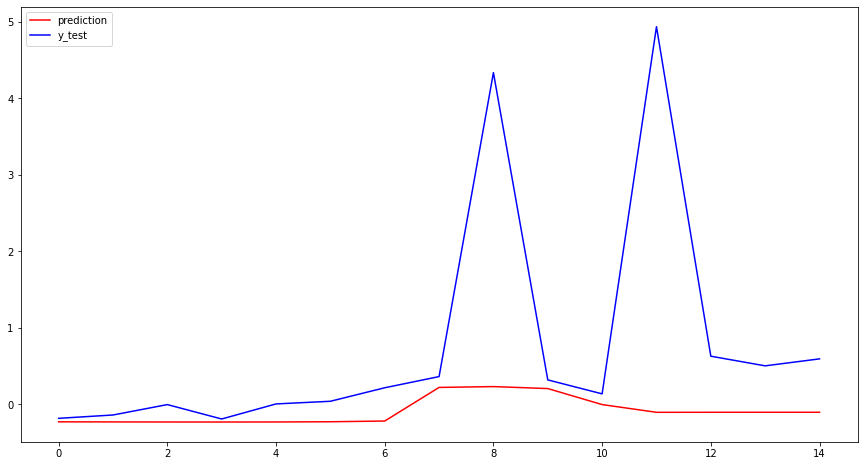

In [71]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()